Significant a-matrix & b-vector overhaul. The implementation enforces an "excess vertical velocity" of 1 in heaving regions, with the rest of the fluid motion parallel to the surface. How to compute the hydro coefficients is also investigated — it must be done empirically by sampling potentials along the surface, since there is no closed-form integral along the surface.

In [1]:
import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))
from helpers import *
import numpy as np
from math import sqrt, cos, sin, pi

import matplotlib.pyplot as plt

In [2]:
h = 50
a = [4, 9]
d_in = [30, 30]
d_out = [30, 5]
heaving = [0, 1]
m0 = 1
rho = 1023

In [3]:
class SProblem1(SProblem):
    # No change in potential matching, alterations are all to velocity matching.
    def b_velocity_entry(self, n, i): # for two i-type regions
        h, d, a, heaving = self.h, self.d, self.a, self.heaving
        if n == 0:
            return (heaving[i+1] - heaving[i]) * (a[i]/2)
        if d[i] > d[i + 1]: #using i+1's vertical eigenvectors
            if heaving[i]:
                num = - sqrt(2) * a[i] * sin(self.lambda_ni(n, i+1) * (h-d[i]))
                denom = (2 * (h - d[i]) * self.lambda_ni(n, i+1))
                base =  num/denom
            else: base = 0
            if heaving[i + 1] and self.slopes[i + 1] != 0:
                lambda0 = self.lambda_ni(n, i + 1)
                t1 = sin(lambda0 * (h - d[i])) / lambda0
                t2_top = ((-1) ** n)/((h - d[i + 1]) * lambda0 **2)
                t2_bot = (cos(lambda0 * (h - d[i]))/(lambda0**2) + (h - d[i]) * sin(lambda0 * (h - d[i]))/lambda0)/(h - d[i + 1])
                correction = sqrt(2) * (1/self.slopes[i + 1]) * (t1 + t2_top - t2_bot)
            else: correction = 0
            return base + correction
        else: #using i's vertical eigenvectors
            if heaving[i+1]:
                num = sqrt(2) * a[i] * sin(self.lambda_ni(n, i) * (h-d[i+1]))
                denom = (2 * (h - d[i+1]) * self.lambda_ni(n, i))
                base = num/denom
            else: base = 0
            if heaving[i] and self.slopes[i] != 0:
                lambda0 = self.lambda_ni(n, i)
                t1 = sin(lambda0 * (h - d[i + 1])) / lambda0
                t2_top = ((-1) ** n)/((h - d[i]) * lambda0 **2)
                t2_bot = (cos(lambda0 * (h - d[i + 1]))/(lambda0**2) + (h - d[i+1]) * sin(lambda0 * (h - d[i+1]))/lambda0)/(h - d[i])
                correction = - sqrt(2) * (1/self.slopes[i]) * (t1 + t2_top - t2_bot)
            else: correction = 0
            return base + correction
    # no modification for end entry
    # Alterations to A matrix: None to potential, many to velocity
    def a_matrix_correction(self, i, j, n, m): # i = region #, j = adjacent region #
        if self.slopes[i] == 0: return 0
        if n == 0: return 0
        d1 = self.d[j]
        # d2 = self.d[i]
        h = self.h
        lambda_n = self.lambda_ni(n, i)
        if m == 0:
            prefactor = sqrt(2) * (1/self.slopes[i])
            t_d1 = - cos(lambda_n * (h - d1))
            t_d2 = - (-1) ** n
            return prefactor * (t_d2 - t_d1)
        lambda_m = self.lambda_ni(m, i)
        prefactor = 2 * (1/self.slopes[i]) * lambda_n
        if m == n:
            t_d1 = - (cos(lambda_m * (h - d1)) ** 2) / (2 * lambda_m)
            t_d2 = - 1 / (2 * lambda_m)
            return prefactor * (t_d2 - t_d1)
        else: # m != n
            t_d1 = (1/2) * (cos((lambda_m - lambda_n) * (h - d1))/(lambda_m - lambda_n) - cos((lambda_m + lambda_n) * (h - d1))/(lambda_m + lambda_n))
            t_d2 = (1/2) * ((-1)**(m-n)/(lambda_m - lambda_n) - (-1)**(m+n)/(lambda_m + lambda_n))
            return prefactor * (t_d2 - t_d1)
        
    def v_diagonal_block(self, left, radfunction, radfunction_corr, bd):
        h, d, a, NMK = self.h, self.d, self.a, self.NMK
        region = bd if left else (bd + 1)
        adj = bd + 1 if left else bd
        sign = (-1) if left else (1)
        diag_block = (h - d[region]) * np.diag(radfunction(list(range(NMK[region])), a[bd], region))
        radial_vector = radfunction_corr(list(range(NMK[region])), a[bd], region)
        radial_array = np.outer((np.full((NMK[region]), 1)), radial_vector)
        m, n = np.indices((NMK[region], NMK[region]))
        correction = np.vectorize(self.a_matrix_correction)(region, adj, n, m)
        corr_block = correction * radial_array
        return sign * (diag_block + corr_block)
    
    #############################################
    # A matrix calculations, only difference is passing inputs to v_diagonal_block
    def a_matrix(self):
        d, NMK, boundary_count, size = self.d, self.NMK, self.boundary_count, self.size
        # localize eigenfunctions
        R_1n, R_2n, diff_R_1n, diff_R_2n = self.R_1n, self.R_2n, self.diff_R_1n, self.diff_R_2n
        # localize block functions
        p_diagonal_block = self.p_diagonal_block
        p_dense_block, p_dense_block_e = self.p_dense_block, self.p_dense_block_e
        v_diagonal_block, v_diagonal_block_e = self.v_diagonal_block, self.v_diagonal_block_e
        v_dense_block, v_dense_block_e = self.v_dense_block, self.v_dense_block_e

        # compute the coupling integrals and store values
        I_nm_vals = self.I_nm_vals()
        I_mk_vals = self.I_mk_vals()

        rows = [] # collection of rows of blocks in A matrix, to be concatenated later

        # Potential Blocks
        col = 0
        for bd in range(boundary_count):
            N = NMK[bd]
            M = NMK[bd + 1]
            if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
                row_height = N
                left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                right_block = p_dense_block_e(bd, I_mk_vals)
                if bd == 0: # one cylinder
                    rows.append(np.concatenate((left_block1,right_block), axis = 1))
                else:
                    left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                    left_zeros = np.zeros((row_height, col), dtype=complex)
                    rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
            elif bd == 0:
                left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block = p_diagonal_block(True, np.vectorize(R_1n), 0)
                    right_block1 = p_dense_block(False, np.vectorize(R_1n), 0, I_nm_vals)
                    right_block2 = p_dense_block(False, np.vectorize(R_2n), 0, I_nm_vals)
                else:
                    row_height = M
                    left_block = p_dense_block(True, np.vectorize(R_1n), 0, I_nm_vals)
                    right_block1 = p_diagonal_block(False, np.vectorize(R_1n), 0)
                    right_block2 = p_diagonal_block(False, np.vectorize(R_2n), 0)
                right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
                block_lst = [left_block, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += N
            else: # i-i boundary
                left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                    left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                    right_block1 = p_dense_block(False, np.vectorize(R_1n),  bd, I_nm_vals)
                    right_block2 = p_dense_block(False, np.vectorize(R_2n),  bd, I_nm_vals)
                else:
                    row_height = M
                    left_block1 = p_dense_block(True, np.vectorize(R_1n),  bd, I_nm_vals)
                    left_block2 = p_dense_block(True, np.vectorize(R_2n),  bd, I_nm_vals)
                    right_block1 = p_diagonal_block(False, np.vectorize(R_1n),  bd)
                    right_block2 = p_diagonal_block(False, np.vectorize(R_2n),  bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                right_zeros = np.zeros((row_height, size - (col + 2 * N + 2 * M)),dtype=complex)
                block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += 2 * N

        # Velocity Blocks
        col = 0
        for bd in range(boundary_count):
            N = NMK[bd]
            M = NMK[bd + 1]
            if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
                row_height = M
                left_block1 = v_dense_block_e(np.vectorize(diff_R_1n, otypes=[complex]), bd, I_mk_vals)
                right_block = v_diagonal_block_e(bd)
                if bd == 0: # one cylinder
                    rows.append(np.concatenate((left_block1,right_block), axis = 1))
                else:
                    left_block2 = v_dense_block_e(np.vectorize(diff_R_2n, otypes=[complex]), bd, I_mk_vals)
                    left_zeros = np.zeros((row_height, col), dtype=complex)
                    rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
            elif bd == 0:
                left_diag = d[bd] <= d[bd + 1] # taller fluid region gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]), 0)
                    right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                    right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0, I_nm_vals)
                else:
                    row_height = M
                    left_block = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                    right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]),0)
                    right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), np.vectorize(R_2n, otypes=[complex]),0)
                right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
                block_lst = [left_block, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += N
            else: # i-i boundary
                left_diag = d[bd] <= d[bd + 1] # taller fluid region gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block1 = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]), bd)
                    left_block2 = v_diagonal_block(True, np.vectorize(diff_R_2n, otypes=[complex]), np.vectorize(R_2n, otypes=[complex]), bd)
                    right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                    right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
                else:
                    row_height = M
                    left_block1 = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                    left_block2 = v_dense_block(True, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
                    right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]), bd)
                    right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), np.vectorize(R_2n, otypes=[complex]), bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                right_zeros = np.zeros((row_height, size - (col + 2* N + 2 * M)),dtype=complex)
                block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += 2 * N

        ## Concatenate the rows of blocks into the square A matrix
        return np.concatenate(rows, axis = 0)

In [4]:
x1, cs1, prob1 = solve_problem(SProblem1, h, a, d_in, d_out, heaving, m0, rho, 40, 1)
x2, cs2, prob2 = solve_problem(SProblem1, h, a, d_in, d_out, heaving, m0, rho, 40, 2)
x3, cs3, prob3 = solve_problem(SProblem1, h, a, d_in, d_out, heaving, m0, rho, 40, 3)

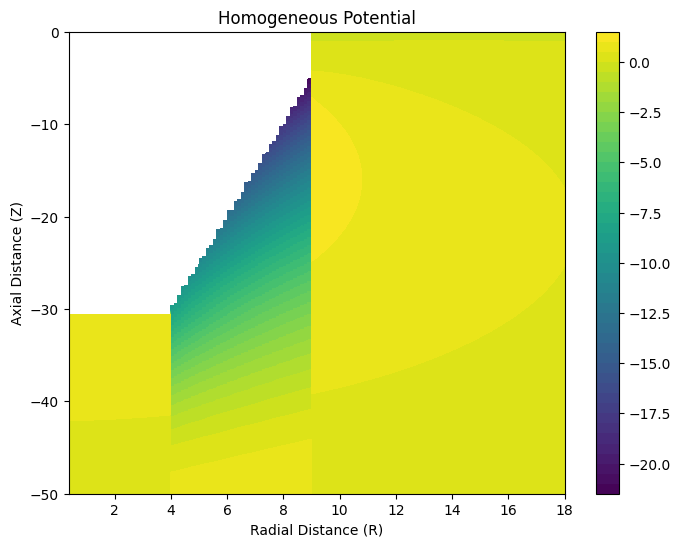

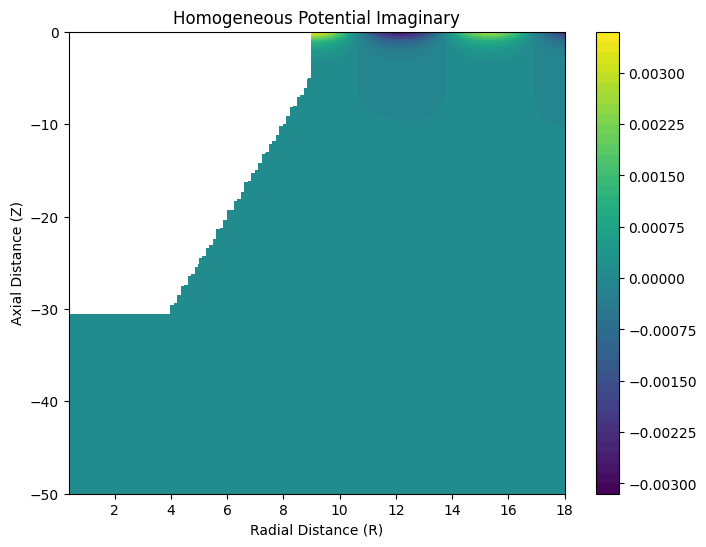

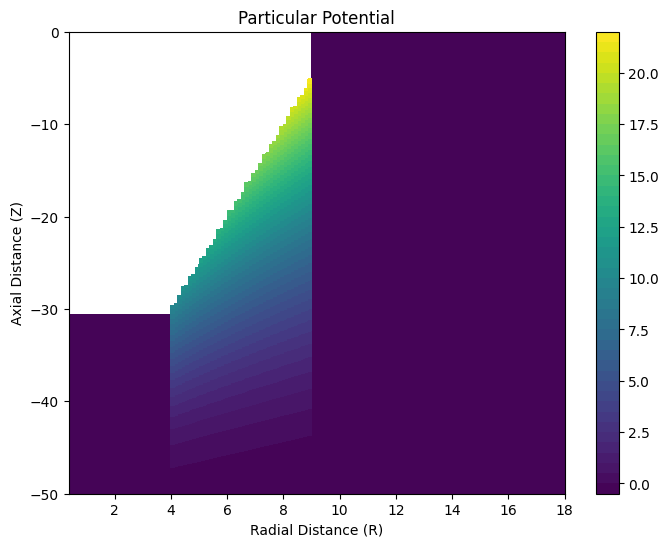

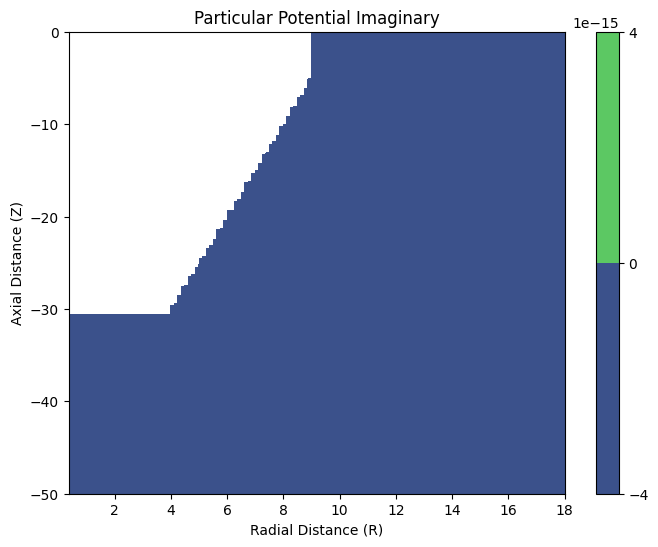

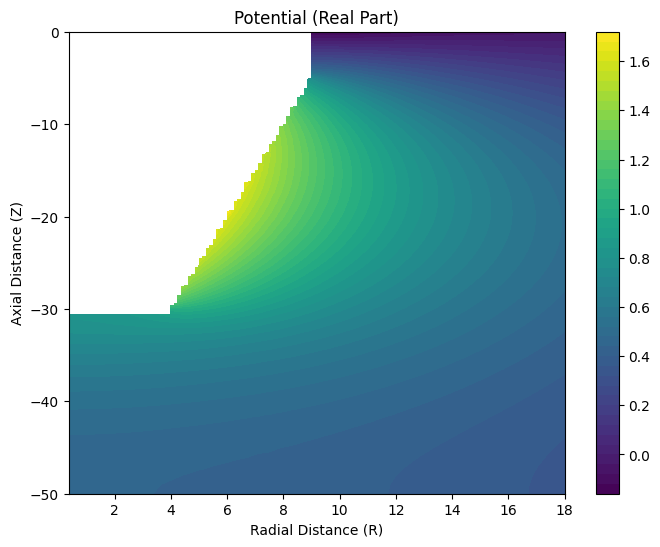

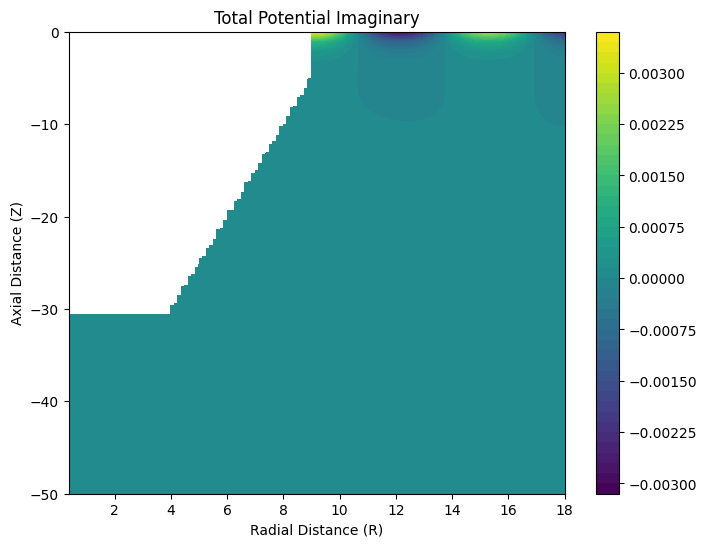

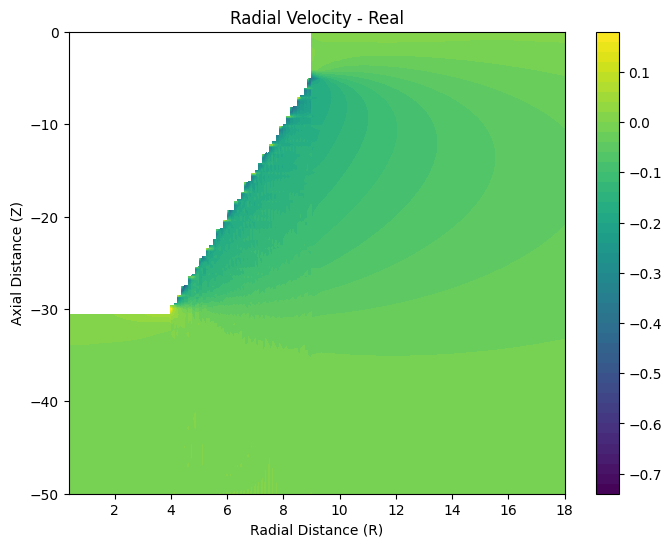

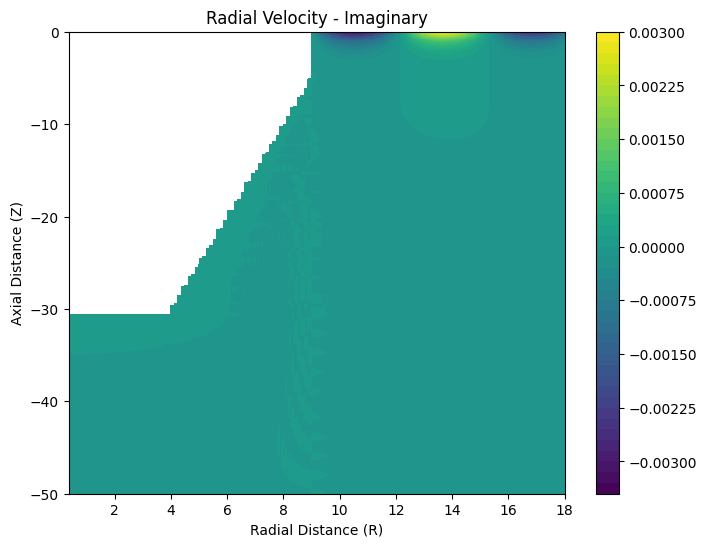

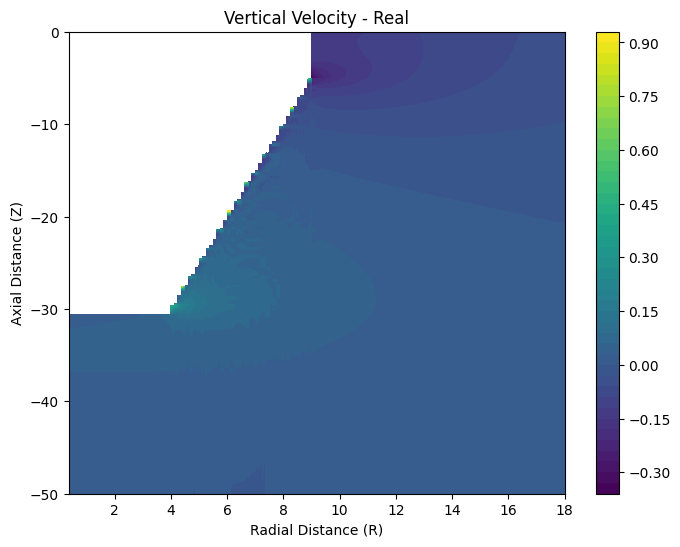

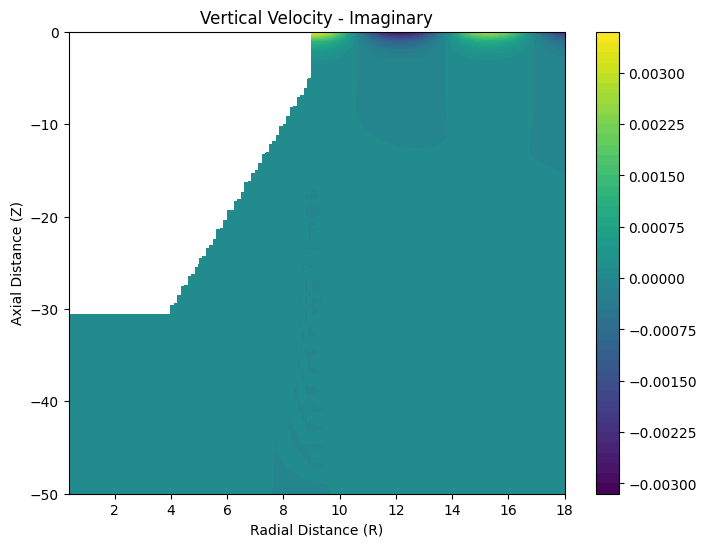

In [9]:
plot_both(prob1, cs1)

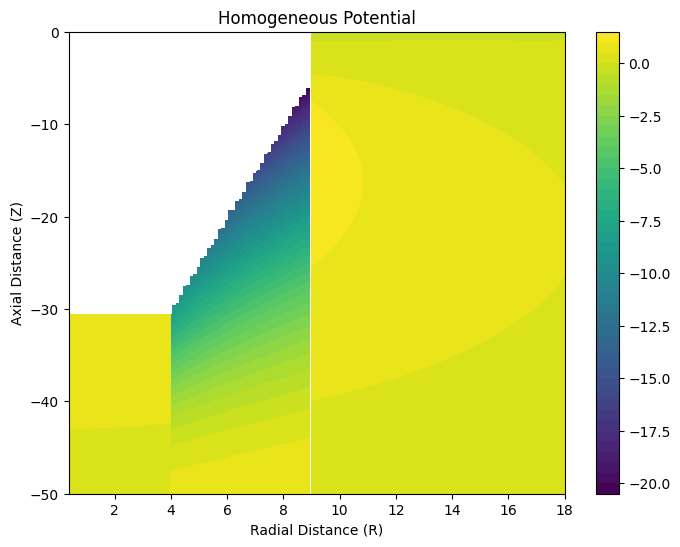

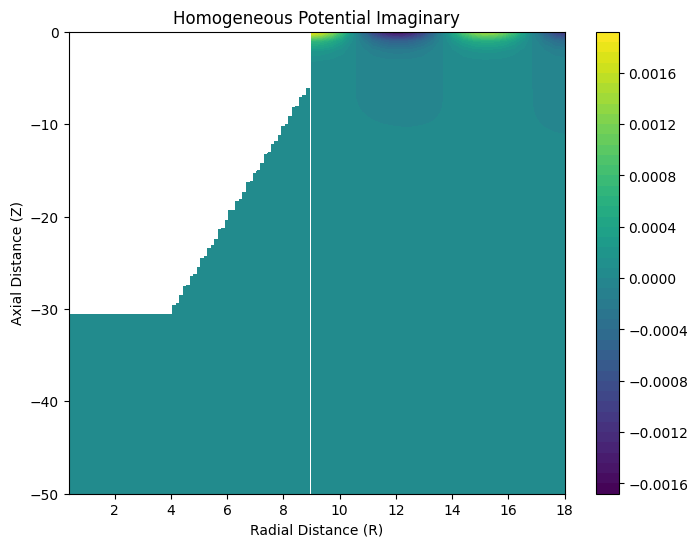

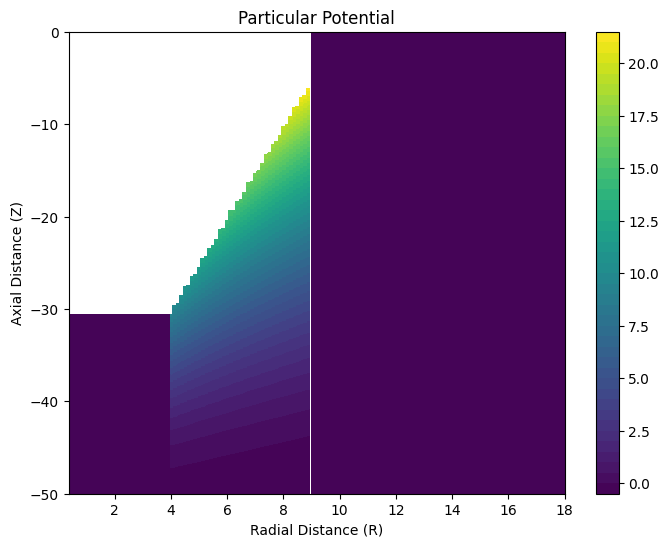

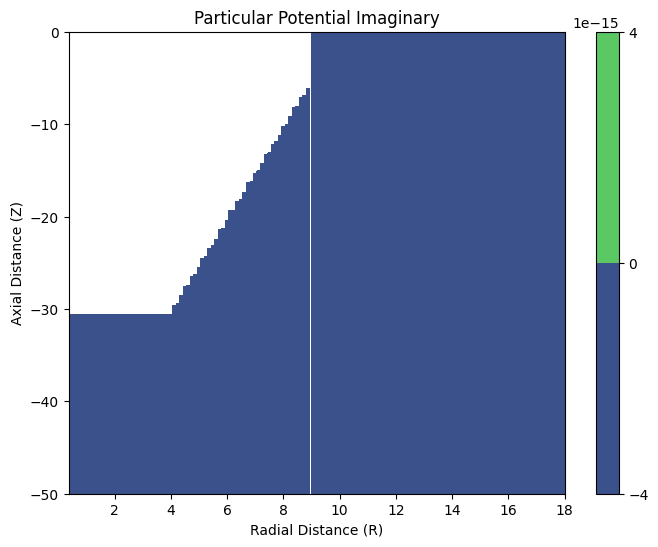

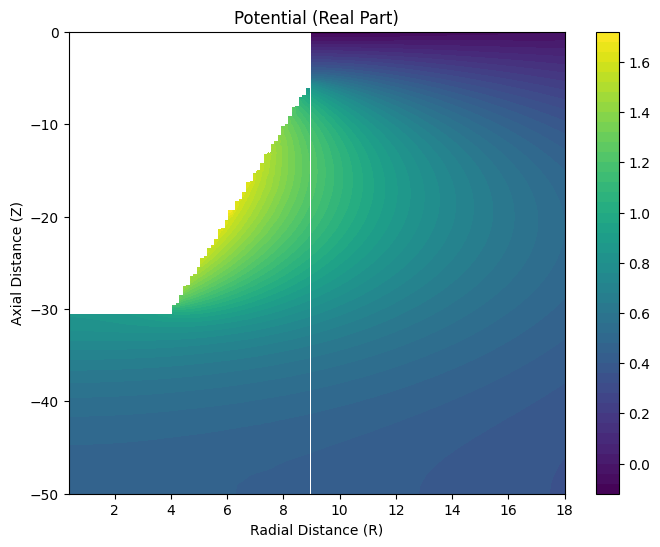

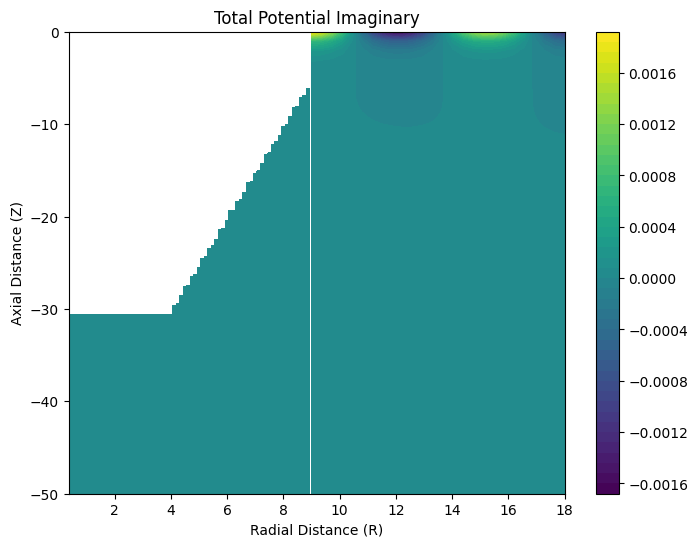

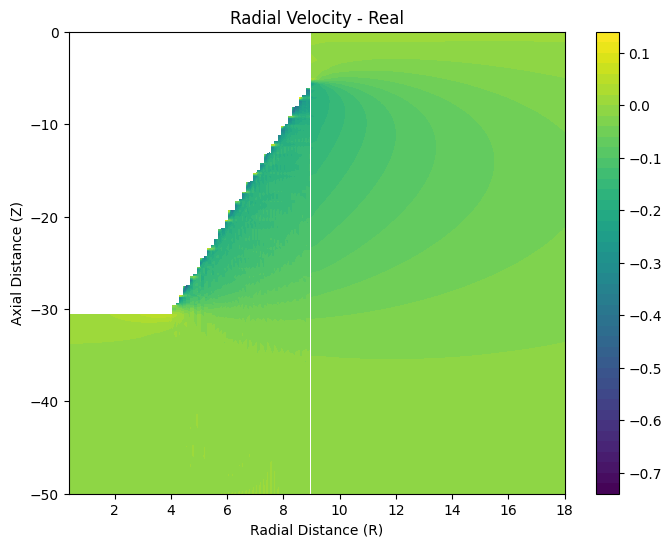

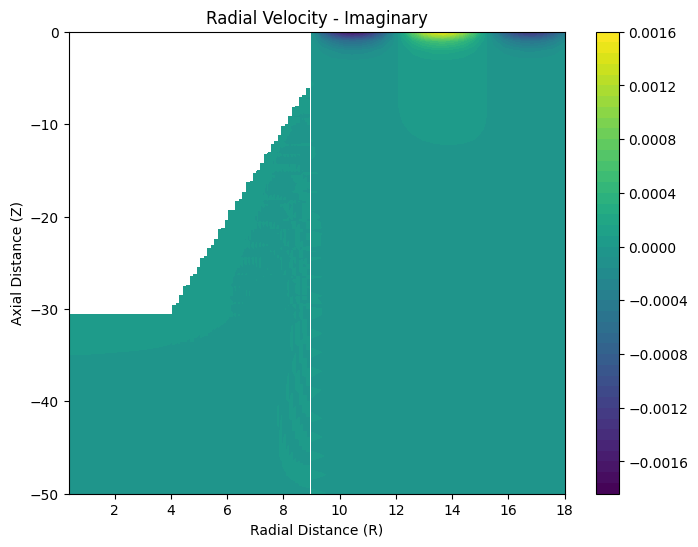

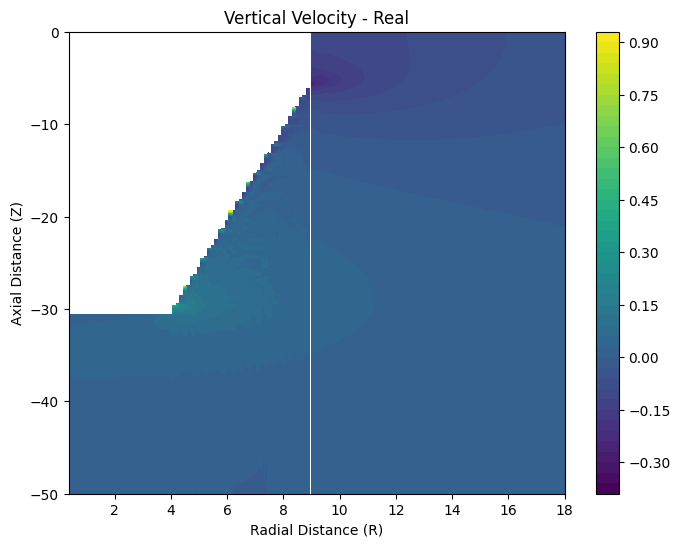

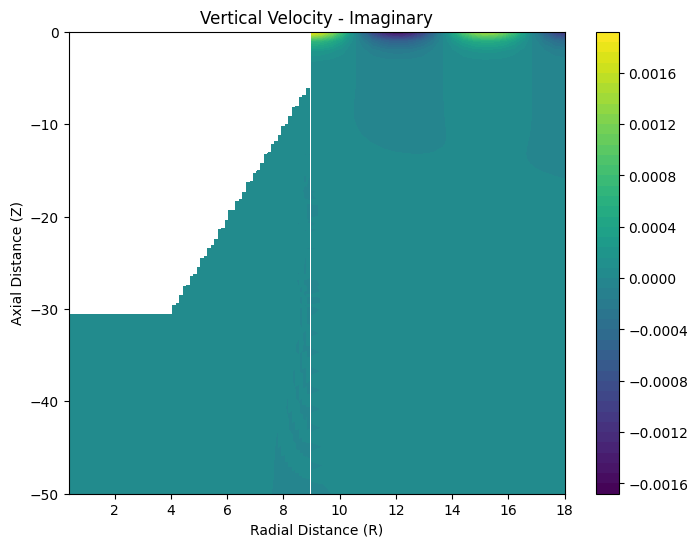

In [10]:
plot_both(prob2, cs2)

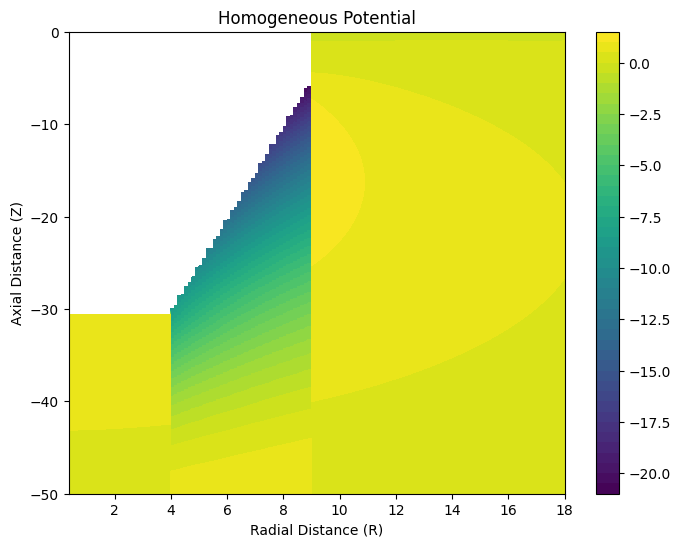

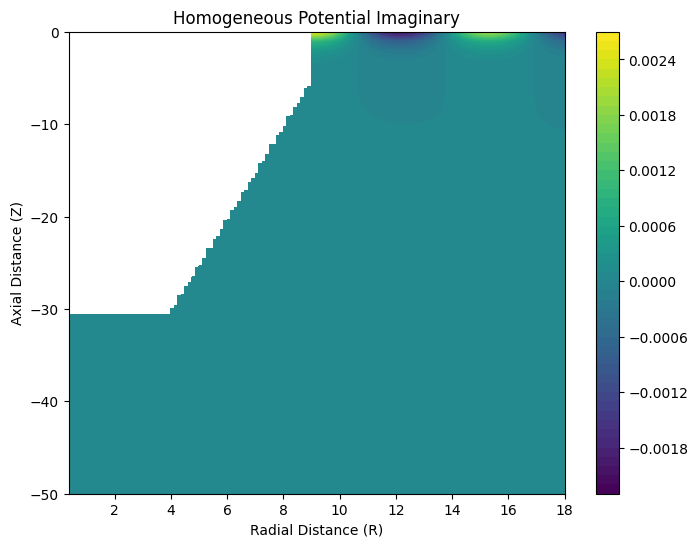

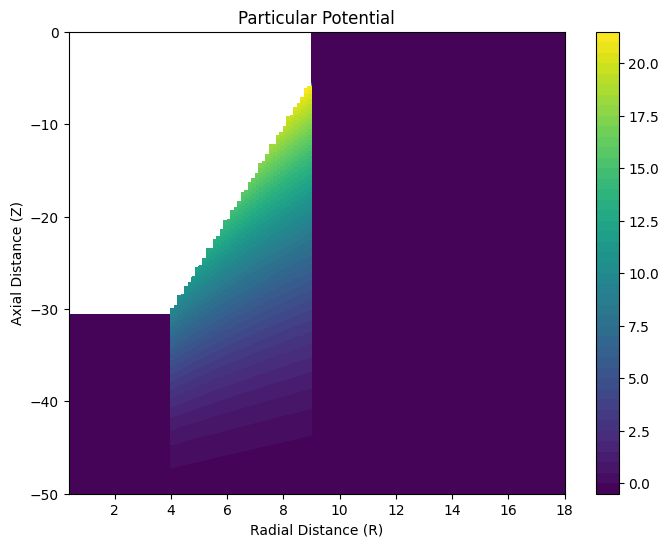

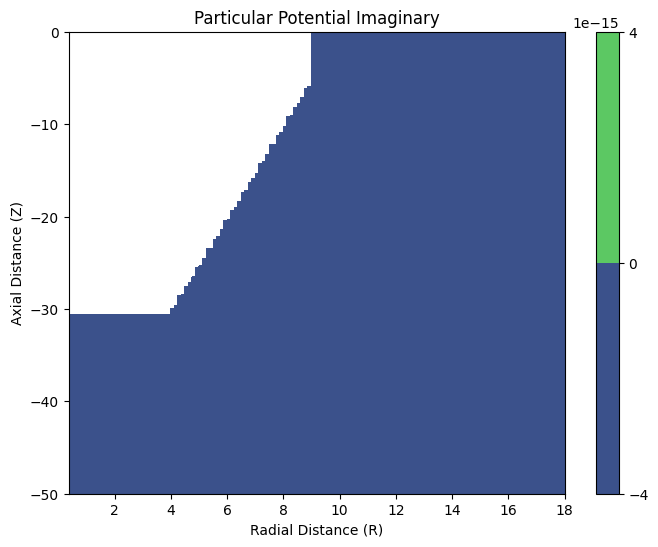

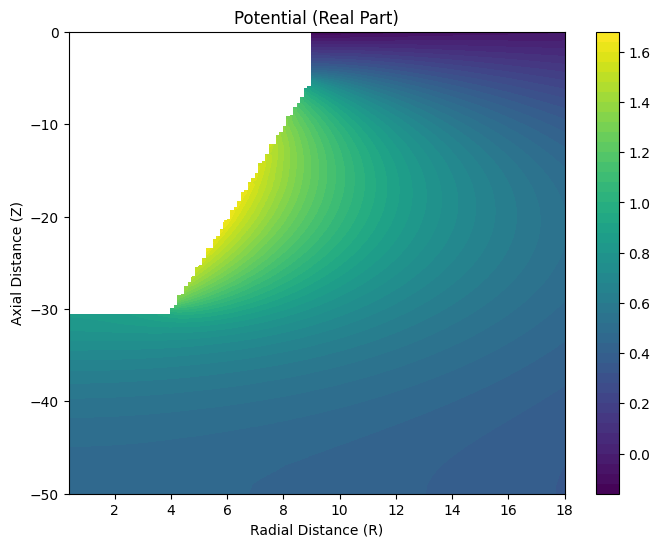

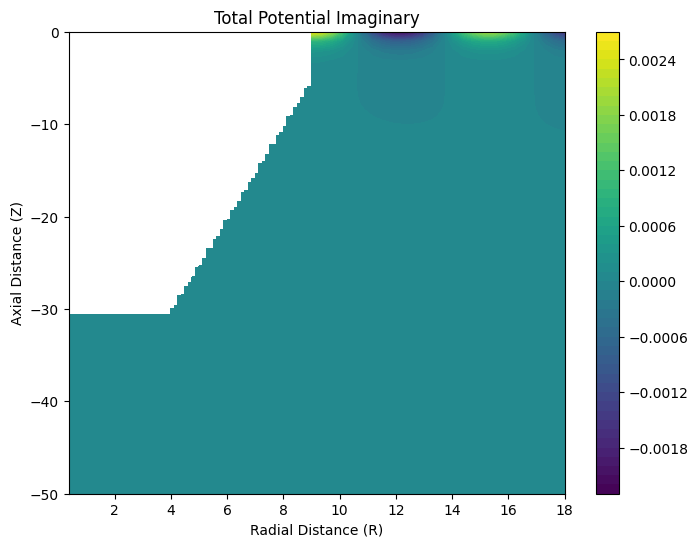

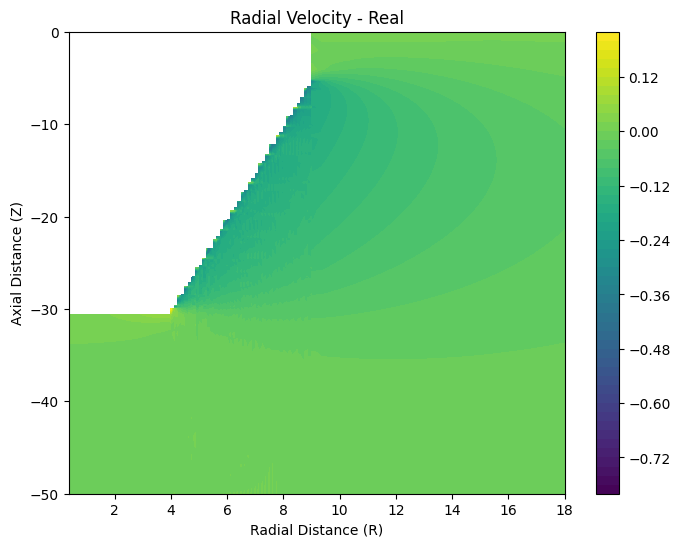

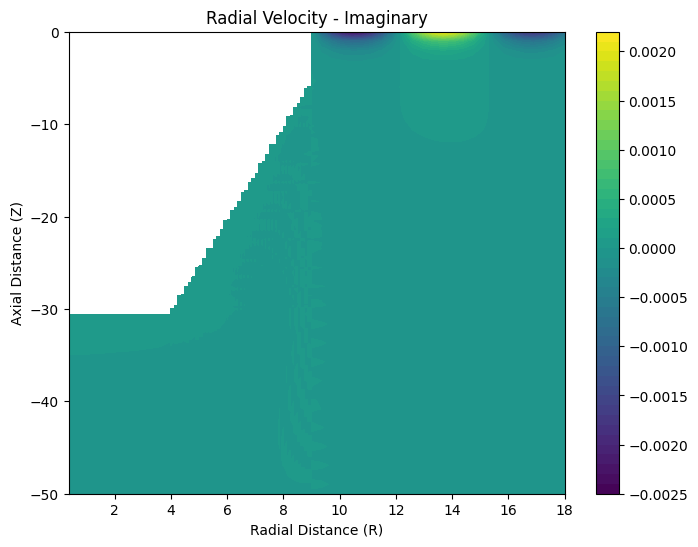

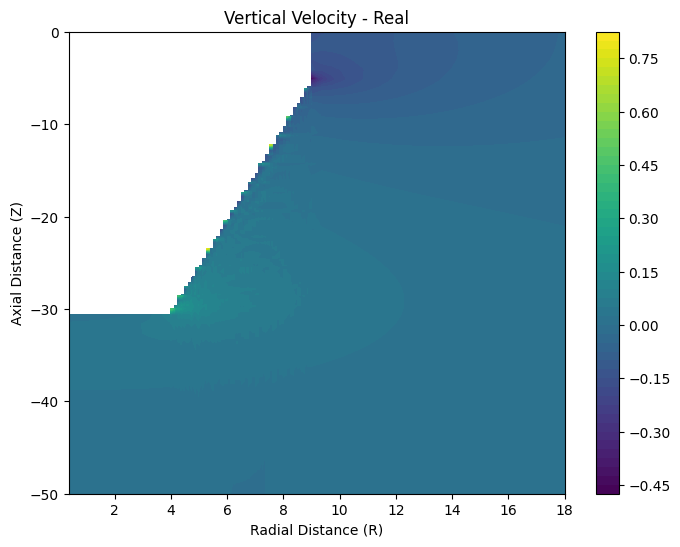

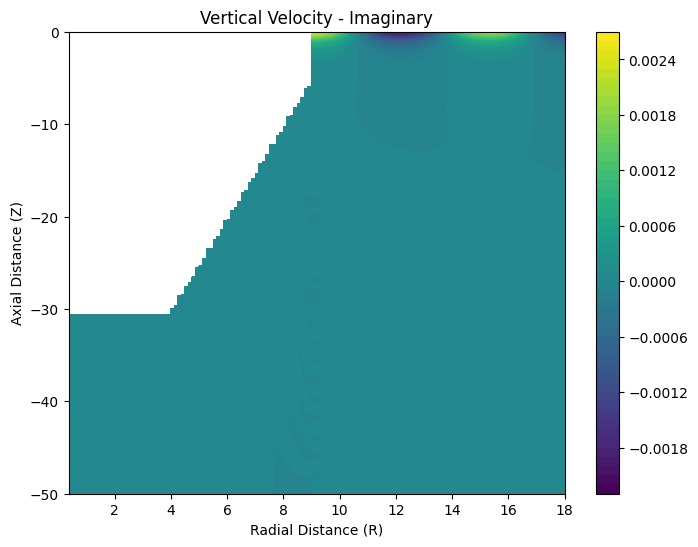

In [11]:
plot_both(prob3, cs3)

In [5]:
def outline_function(r):
  region = 0
  for rad in a:
    if r <= rad: break
    else: region += 1
  if region == len(a): return 0
  elif d_in[region] == d_out[region]:
    return - d_in[region]
  else:
    inner_rad = 0 if region == 0 else a[region - 1]
    outer_rad = a[region]
    slope = (d_in[region] - d_out[region])/(outer_rad - inner_rad)
    return slope * (r - inner_rad) - d_in[region]

In [6]:
class SProblem2(SProblem1):
  def phi_p_i(self, r, z, i): # particular solution
      return (1 / (2* (self.h - self.d[i]))) * ((z + self.h) ** 2 - (r**2) / 2)
  
  def potential(self, r, z, cs):
    region = self.det_region(r)
    nmk = self.NMK[region]
    nmks = list(range(nmk))
    if region == self.boundary_count: # Outermost
      lambda_vals = np.vectorize(self.Lambda_k, otypes=[complex])(nmks, r)
      z_vals = np.vectorize(self.Z_k_e, otypes=[complex])(nmks, z)
      return np.dot(cs[-1], lambda_vals * z_vals)
    else:
      phi_p = 0 if not self.heaving[region] else self.phi_p_i(r, z, region)
      r1_vals = np.vectorize(self.R_1n, otypes=[complex])(nmks, r, region)
      z_vals = np.vectorize(self.Z_n_i, otypes=[complex])(nmks, z, region)
      phi_h_1 = np.dot(cs[region][:nmk], r1_vals * z_vals)
      if region == 0: # Innermost
        return phi_p + phi_h_1
      else: # Typical region
        r2_vals = np.vectorize(self.R_2n, otypes=[complex])(nmks, r, region)
        phi_h_2 = np.dot(cs[region][nmk:], r2_vals * z_vals)
        return phi_p + phi_h_1 + phi_h_2
    
  def regional_value(self, i, cs, outline_function, frac1, frac2 = None):
    inner_rad = 0 if i == 0 else self.a[i - 1]
    outer_rad = self.a[i]
    rad1 = frac1 * (outer_rad - inner_rad) + inner_rad
    p1 = self.potential(rad1, outline_function(rad1), cs)
    if frac2 is None:
      return p1 * (outer_rad **2 - inner_rad **2)/2
    else:
      rad2 = frac2 * (outer_rad - inner_rad) + inner_rad
      p2 = self.potential(rad2, outline_function(rad2), cs)
      mid_rad = inner_rad + (outer_rad - inner_rad)/2
      v1 = p1 * (mid_rad **2 - inner_rad **2)/2
      v2 = p2 * (outer_rad **2 - mid_rad **2)/2
      return v1 + v2

  # Compute hydro-coefficients by approximating potential on each surface as equal the potential at a specific point
  # a fraction of the way along that surface
  def hydros_by_averages(self, cs, outline_function, convention, frac1 = 0.5, frac2 = None):
    accumulator = 0
    for region in range(self.boundary_count):
      if self.heaving[region]:
        if self.slopes[region] == 0: # typical calculation
          nmk = self.NMK[region]
          r1 = np.dot([self.int_R_1n(region, m)* self.z_n_d(m) for m in range(nmk)], cs[region][:nmk])
          if region == 0:
            accumulator += (r1 + self.int_phi_p_i(region))
          else:
            r2 = np.dot([self.int_R_2n(region, m)* self.z_n_d(m) for m in range(nmk)], cs[region][nmk:])
            accumulator += (r1 + r2 + self.int_phi_p_i(region))
        else:
          accumulator += self.regional_value(region, cs, outline_function, frac1, frac2)

    hydro_coef = 2 * pi * accumulator
    if convention == "nondimensional":
        # find maximum heaving radius
        max_rad = self.a[0]
        for i in range(self.boundary_count - 1, 0, -1):
            if self.heaving[i]:
                max_rad = self.a[i]
                break
        hydro_coef_nondim = self.h**3/(max_rad**3 * pi)*hydro_coef
        added_mass = hydro_coef_nondim.real
        damping = hydro_coef_nondim.imag
    elif convention == "umerc":
        added_mass = hydro_coef.real * self.h**3 * self.rho
        damping = hydro_coef.imag * self.angular_freq(self.m0) * self.h**3 * self.rho
    elif convention == "capytaine":
        added_mass = hydro_coef.real * self.rho
        damping = hydro_coef.imag * self.angular_freq(self.m0) * self.rho
    else:
        raise ValueError("Allowed conventions are nondimensional, umerc, and capytaine.")
    return added_mass, damping
    

In [7]:
def construct_problem(prob_style, h, a, d_in, d_out, heaving, m0, rho, res, version):
  NMK = [150, 150, 150]
  d_prime, a_prime, heaving_prime, NMK_prime, slopes = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = prob_style(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho, slopes)
  return prob

def plot_contour(prob, cs, r_min, r_max, z_min, z_max, res = 50):
    # Generate grid
    r = np.linspace(r_min, r_max, res)
    z = np.linspace(z_min, z_max, res)
    R, Z = np.meshgrid(r, z)

    # Evaluate function
    def wrapper(r, z):
        if z > outline_function(r):
            return np.nan + 1j * np.nan
        else: return prob.potential(r, z, cs)
    vals = np.vectorize(wrapper, otypes=[complex])(R, Z)

    # Plot contour
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(R, Z, np.real(vals), cmap='viridis', levels = 50)
    plt.colorbar(contour, label='Function value')
    plt.xlabel('r')
    plt.ylabel('z')
    plt.title('Contour Map')
    plt.show()

def hydro_plot(fracs, all_hydros, hydro_name):
  for i in range(3):
    plt.plot(fracs, all_hydros[i], label = f"Discretization Variant {(i+1)}")
  plt.xlabel("fraction of way along region's surface")
  plt.ylabel(hydro_name + " Calculated")
  plt.grid()
  plt.legend()
  plt.title(hydro_name + " vs. fraction of way along region potential was sampled")
  plt.show()

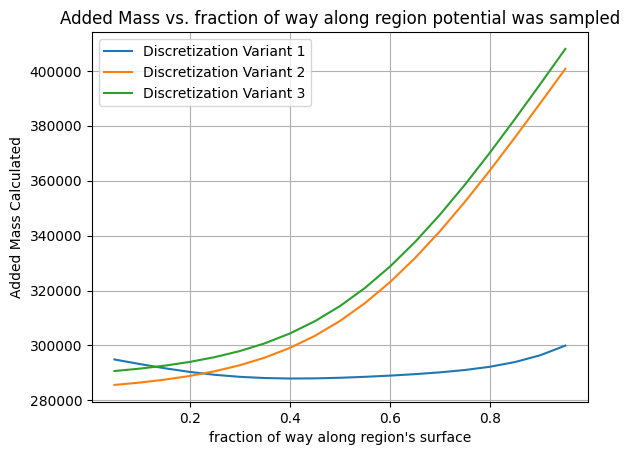

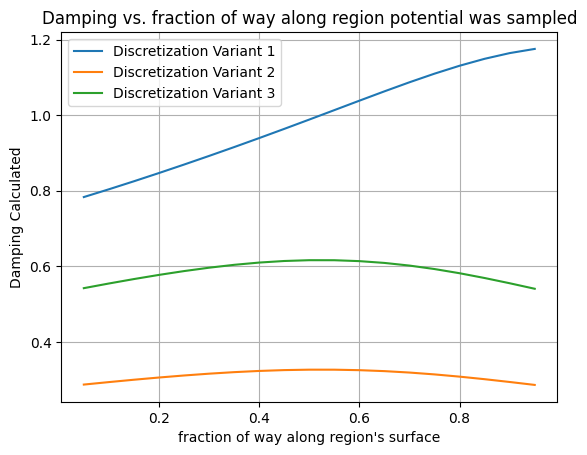

In [9]:
vars = [1, 2, 3]
css = [cs1, cs2, cs3]
prob_hs = [construct_problem(SProblem2, h, a, d_in, d_out, heaving, m0, rho, 40, var) for var in vars]
all_ams, all_dps = [[], [], []], [[], [], []]
fracs = [entry / 20 for entry in range(1, 20)]
for var in vars:
  index = var - 1
  for frac1 in fracs:
    am, dp = prob_hs[index].hydros_by_averages(css[index], outline_function, "capytaine", frac1)
    all_ams[index].append(am)
    all_dps[index].append(dp)

hydro_plot(fracs, all_ams, "Added Mass")
hydro_plot(fracs, all_dps, "Damping")

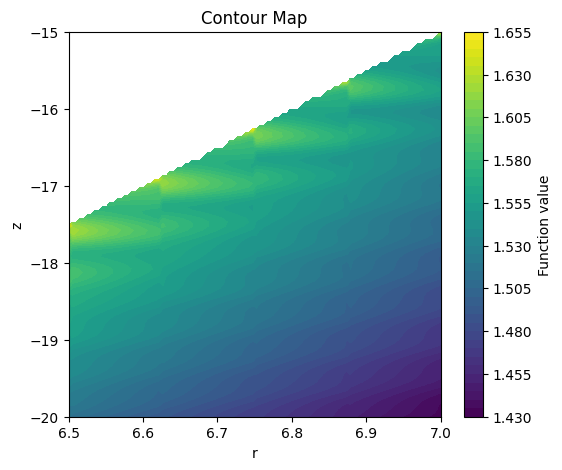

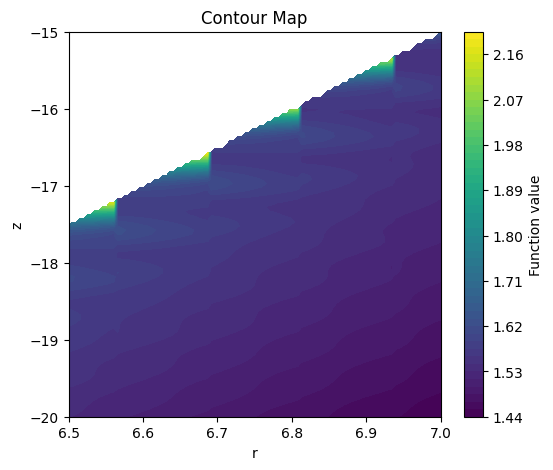

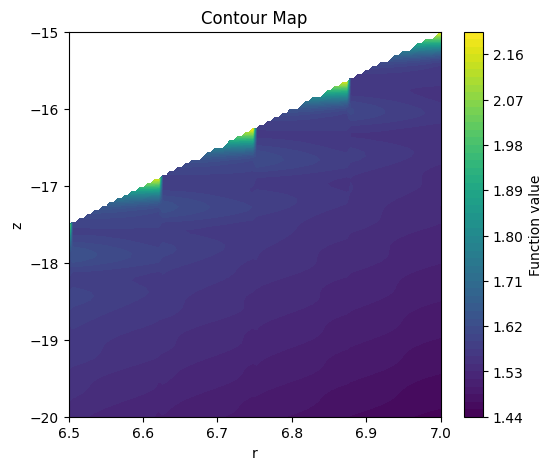

In [10]:
for var in vars:
  plot_contour(prob_hs[var-1], css[var-1], 6.5, 7, -20, -15, res = 100)

In [14]:
ress = [10, 20, 30, 40]
all_res_ams, all_res_dps = [[] for _ in ress], [[] for _ in ress]
for i in range(len(ress)):
  res = ress[i]
  x, cs, prob = solve_problem(SProblem2, h, a, d_in, d_out, heaving, m0, rho, res, 1, nmk = 200)
  print("res =", res)
  for frac1 in [entry / 20 for entry in range(1, 20)]:
    am, dp = prob.hydros_by_averages(cs, outline_function, "capytaine", frac1)
    all_res_ams[i].append(am)
    all_res_dps[i].append(dp)

res = 10
res = 20
res = 30
res = 40


Variant 1


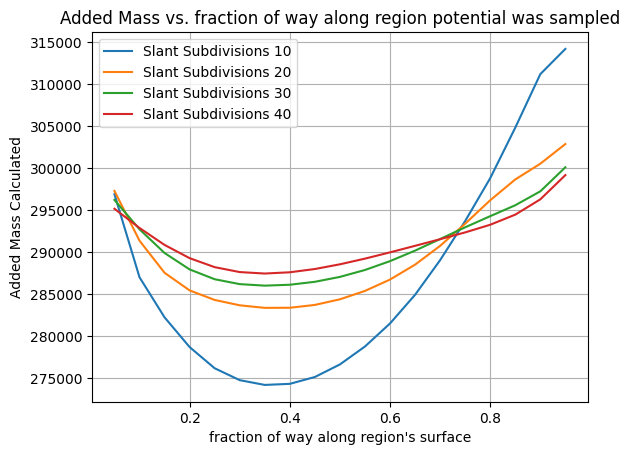

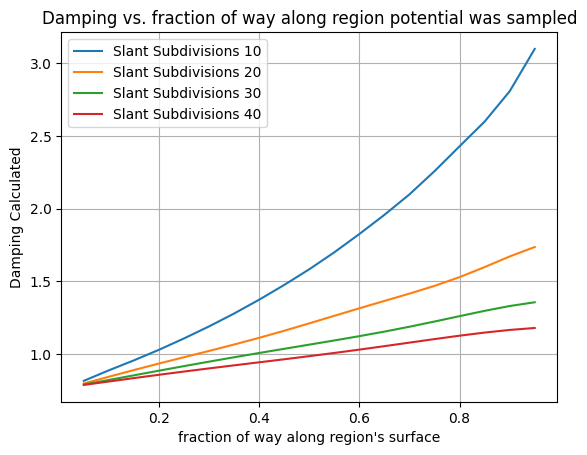

In [15]:
def hydro_plot_res(fracs, all_hydros, hydro_name, ress):
  for i in range(len(ress)):
    plt.plot(fracs, all_hydros[i], label = f"Slant Subdivisions {ress[i]}")
  plt.xlabel("fraction of way along region's surface")
  plt.ylabel(hydro_name + " Calculated")
  plt.grid()
  plt.legend()
  plt.title(hydro_name + " vs. fraction of way along region potential was sampled")
  plt.show()

print("Variant 1")
hydro_plot_res(fracs, all_res_ams, "Added Mass", ress)
hydro_plot_res(fracs, all_res_dps, "Damping", ress)

In [ ]:
# This formulation appears to give a correct macroscopic potential
# Its convergence via slant resolution should be compared to regular MEEM, to see if it converges faster